<a href="https://colab.research.google.com/github/Twahaaa/Micro_grad/blob/main/Neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
%matplotlib inline

In [2]:
class Value:
  def __init__(self,data, _children=(),_op='',label=''):
    self.data=data
    self.grad=0.0
    self._backward=lambda:None
    self.prev=set(_children)
    self._op=_op
    self.label=label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    other=other if isinstance(other, Value) else Value(other)
    out = Value(self.data+other.data, (self, other),'+')
    def _backward():
      self.grad+=1.0*out.grad # '+=' because in case of multivariate case (where 2 nodes use the same value like b=a+c d=b+a, we accumulate the gradients or else it'll be initialised to 1)
      other.grad+=1.0*out.grad
    out._backward=_backward
    return out


  def __mul__(self,other):
    other=other if isinstance(other, Value) else Value(other)
    out = Value(self.data*other.data, (self, other), '*')
    def _backward():
      self.grad+=other.data*out.grad
      other.grad+=self.data*out.grad
    out._backward=_backward
    return out

  def __pow__(self,other):
    assert isinstance(other, (int,float)) #The reason why its 'other' and not 'other.data' is becase the power should always be an int or a float not an object ad that's why the assertiion is there
    out=Value(self.data**other, (self, ), f'**{other}')
    def _backward():
      self.grad+= other*(self.data**other-1)*out.grad
    out._backward=_backward
    return out


  def __radd__(self,other):
    return self+other

  def __rmul__(self,other):
    return self*other

  def __truediv__(self,other):
    return self*other**-1

  def __neg__(self):
    return self*-1

  def __sub__(self,other):
    return self+(-other)

  def __rsub__(self,other):
    return self+(-other)

  def tanh(self):
    x=self.data
    t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
    out=Value(t,(self,),'tanh')
    def _backward():
      self.grad+=(1-t**2)*out.grad
    out._backward=_backward
    return out

  def exp(self):
    x=self.data
    out=Value(math.exp(x),(self, ),'exp')
    def _backward():
      self.grad+=out.data*out.grad
    out._backward=_backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad=1.0
    for node in reversed(topo):
      node._backward()

In [3]:
from graphviz import Digraph
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data ,n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

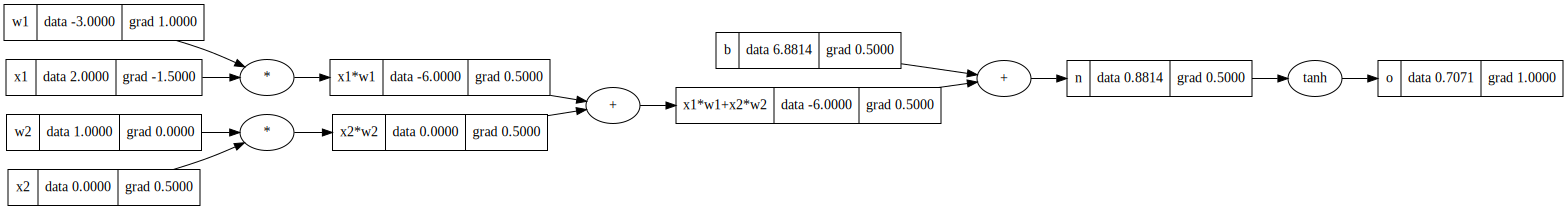

In [4]:
#inputs
x1=Value(2.0,label='x1')
x2=Value(0.0,label='x2')
#weights
w1=Value(-3.0,label='w1')
w2=Value(1.0,label='w2')
#bias
b=Value(6.8813735870195432,label='b')

x1w1=x1*w1;x1w1.label='x1*w1'
x2w2=x2*w2;x2w2.label='x2*w2'

x1w1x2w2=x1w1+x2w2;x1w1x2w2.label='x1*w1+x2*w2'
n=x1w1x2w2+b;n.label='n'
o=n.tanh();o.label='o';
o.backward()
draw_dot(o)

In [5]:
class Nueron:
  def __init__(self,nin):#nin is the number of input values for each nueron
    self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b=Value(random.uniform(-1,1))

  def __call__(self,x):#x is for w*x+b
    act=sum((wi * xi for wi,xi in zip(self.w,x)), self.b)#here b is the staring point for wx+b
    out=act.tanh()#act meaning the variable to be passed through the activation function, in this case its tan
    return out

  def parameters(self):
    return self.w+[self.b]

class Layer:
  def __init__(self,nin,nout):#nout is the number of output nuerons
    self.nuerons=[Nueron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs=[n(x) for n in self.nuerons]
    return outs[0] if len(outs)==1 else outs

  def parameter(self):
    return [p for nueron in self.nuerons for p in nueron.parameters()]

class MLP:
  def __init__(self,nin,nouts):
    sz=[nin]+nouts
    self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x=layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameter()]




In [6]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.9278725234522754)

In [8]:
xs=[[2.0,3.0,-1.0],[3.0,-1.0,0.5],[0.5,1.0,1.0],[1.0,1.0,-1.0],]
ys=[1.0,-1.0,-1.0,1.0]

0 7.524778168355881
1 7.77695912647277
2 8.132057706009478
3 9.783948812290376
4 8.143833281830481
5 9.18668707631278
6 8.541875786362478
7 9.332814494480555
8 8.461059023272533
9 9.429256621286553
10 8.418500386658831
11 9.429166263646794
12 8.44483608478925
13 9.413645152169414
14 8.476789462852594
15 9.400181323921352
16 8.503391162591043
17 9.387701341480414
18 8.52657537278628
19 9.375829859457925


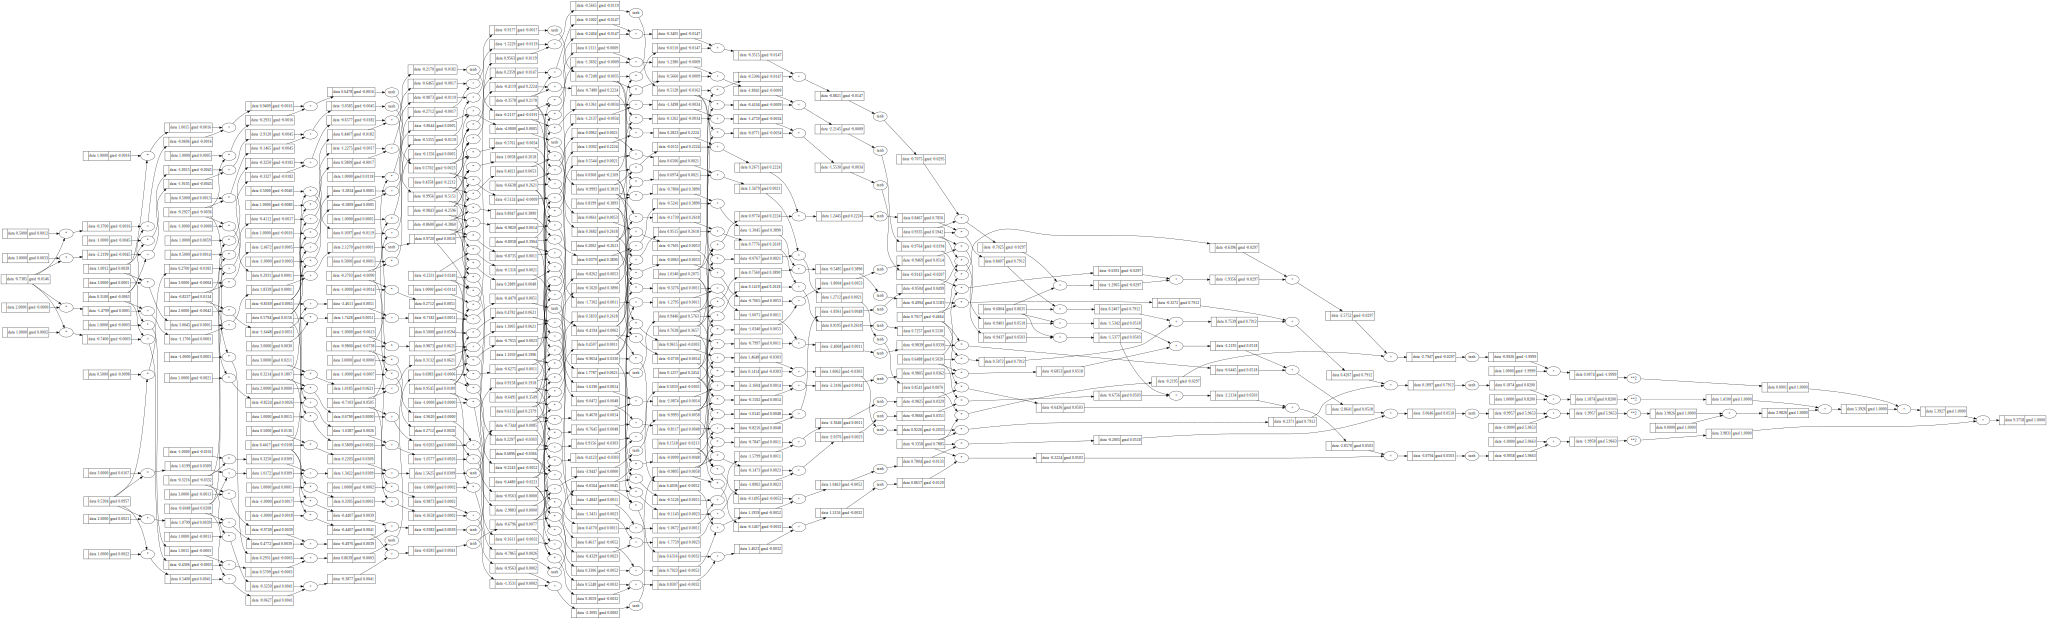

In [9]:
for k in range(20):
  #forward pass
  ypred=[n(x) for x in xs]
  loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred)) #ygt is ground truth, meaning the desired output and yout is the prediction output from out neural network

  #backward pass
  for p in n.parameters():
    p.grad=0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k,loss.data)
draw_dot(loss)

In [10]:
ypred

[Value(data=-0.9956527977798121),
 Value(data=0.18743790919216533),
 Value(data=-0.9925530736197624),
 Value(data=-0.9957794280111111)]